In [ ]:
! pip install pytorch-forecasting pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving combined_cleaned_train.csv to combined_cleaned_train.csv


In [ ]:
import pandas as pd

combined_train = pd.read_csv("combined_cleaned_train.csv")

In [ ]:
uploaded = files.upload()

Saving combined_cleaned_test.csv to combined_cleaned_test.csv


In [ ]:
combined_test = pd.read_csv("combined_cleaned_test.csv")

In [ ]:
uploaded = files.upload()

Saving neurology_cleaned_train.csv to neurology_cleaned_train.csv


In [ ]:
uploaded = files.upload()

Saving neurology_cleaned_test.csv to neurology_cleaned_test.csv


In [ ]:
neurology_train = pd.read_csv("neurology_cleaned_train.csv")
neurology_test = pd.read_csv("neurology_cleaned_test.csv")

In [ ]:
neurology_train = neurology_train.drop(columns=['valuenum'])
neurology_test = neurology_test.drop(columns=['valuenum'])

In [ ]:
uploaded = files.upload()

Saving fb_cleaned_train.csv to fb_cleaned_train.csv


In [ ]:
uploaded = files.upload()

Saving fb_cleaned_test.csv to fb_cleaned_test.csv


In [ ]:
fb_train = pd.read_csv("fb_cleaned_train.csv")
fb_test = pd.read_csv("fb_cleaned_test.csv")

In [ ]:
fb_train = fb_train.drop(columns=['valuenum'])
fb_test = fb_test.drop(columns=['valuenum'])

In [ ]:
def pivot_fb_data(df):
    # Pivot so that each label becomes a column
    pivot_df = df.pivot_table(
        index=['subject_id', 'stay_id', 'charttime'],
        columns='label',
        values='valuenum_normalized',
        aggfunc='first'  # only needed if duplicates exist, safe to keep
    ).reset_index()

    # Flatten column index
    pivot_df.columns.name = None

    return pivot_df

# Apply to your train and test DataFrames
fb_train1 = pivot_fb_data(fb_train)
fb_test1 = pivot_fb_data(fb_test)

In [ ]:
fb_train1.head()

,subject_id,stay_id,charttime,Fluid balance
0,10002428,38875437,2156-04-22,0.012501
1,10004235,34100191,2196-02-27,0.469383
2,10004401,39699336,2144-06-18,0.006366
3,10013643,33072499,2200-10-02,0.526681
4,10014078,38907302,2166-08-23,0.057183


In [ ]:
uploaded = files.upload()

Saving demographics_cleaned.csv to demographics_cleaned.csv


In [ ]:
demographics = pd.read_csv("demographics_cleaned.csv")

In [ ]:
combined_train = pd.concat([combined_train, neurology_train], axis=0, ignore_index=True)
combined_test = pd.concat([combined_test, neurology_test], axis=0, ignore_index=True)

In [ ]:
combined_train['charttime'] = pd.to_datetime(combined_train['charttime'], errors='coerce')
combined_test['charttime'] = pd.to_datetime(combined_test['charttime'], errors='coerce')

In [ ]:
def pivot_dynamic_features(df):
    # Extract ext_success per subject_id + stay_id
    ext_success_df = df.groupby(['subject_id', 'stay_id'])['ext_success'].first().reset_index()

    # Pivot dynamic features
    pivot_df = df.pivot_table(
        index=['subject_id', 'stay_id', 'charttime'],
        columns='label',
        values='valuenum_normalized',
        aggfunc='first'
    ).reset_index()

    # Flatten multi-index columns if any
    pivot_df.columns.name = None

    # Merge ext_success back in
    pivot_df = pivot_df.merge(ext_success_df, on=['subject_id', 'stay_id'], how='left')

    return pivot_df

In [ ]:
combined_train1 = pivot_dynamic_features(combined_train)
combined_test1 = pivot_dynamic_features(combined_test)

In [ ]:
combined_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169745 entries, 0 to 169744
Data columns (total 55 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   subject_id                             169745 non-null  int64         
 1   stay_id                                169745 non-null  int64         
 2   charttime                              169745 non-null  datetime64[ns]
 3   Alanine Aminotransferase (ALT)         1496 non-null    float64       
 4   Albumin                                835 non-null     float64       
 5   Alkaline Phosphatase                   1626 non-null    float64       
 6   Arterial Blood Pressure diastolic      66533 non-null   float64       
 7   Arterial Blood Pressure mean           66689 non-null   float64       
 8   Arterial Blood Pressure systolic       66535 non-null   float64       
 9   Base Excess                            8954 non-

In [ ]:
def impute_time_series(df):
    # Sort for correct forward/backward fill order
    df = df.sort_values(by=["subject_id", "stay_id", "charttime"]).copy()

    # Identify feature columns (exclude IDs and charttime)
    non_feature_cols = ['subject_id', 'stay_id', 'charttime']
    feature_cols = [col for col in df.columns if col not in non_feature_cols]

    # Forward fill, then backward fill by subject/stay
    df[feature_cols] = (
        df.groupby(['subject_id', 'stay_id'])[feature_cols]
          .apply(lambda group: group.ffill().bfill())
          .reset_index(drop=True)
    )

    # Fill remaining NaNs with median per column
    for col in feature_cols:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

    return df

# Apply to both datasets
combined_train2 = impute_time_series(combined_train1)
combined_test2 = impute_time_series(combined_test1)

/tmp/ipython-input-23-2678007947.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-23-2678007947.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
# Prepare fb data
fb_train_subset = fb_train1[['subject_id', 'stay_id', 'Fluid balance']].rename(columns={'Fluid balance': 'fb'})
fb_test_subset = fb_test1[['subject_id', 'stay_id', 'Fluid balance']].rename(columns={'Fluid balance': 'fb'})

# Merge fb into combined data
combined_train3 = combined_train2.merge(fb_train_subset, on=['subject_id', 'stay_id'], how='left')
combined_test3 = combined_test2.merge(fb_test_subset, on=['subject_id', 'stay_id'], how='left')

# Prepare demographics data
demographics_subset = demographics[['subject_id', 'stay_id', 'Height', 'Weight']]

# merge demographics into combined data (only keep matching rows)
combined_train3 = combined_train3.merge(demographics_subset, on=['subject_id', 'stay_id'], how='inner')
combined_test3 = combined_test3.merge(demographics_subset, on=['subject_id', 'stay_id'], how='inner')

In [ ]:
# Combine subject_id and stay_id for a unique group identifier
for df in [combined_train3, combined_test3]:
    df["group_id"] = df["subject_id"].astype(str) + "_" + df["stay_id"].astype(str)

    # Sort chronologically
    df.sort_values(["group_id", "charttime"], inplace=True)

    # Create a relative time index (per group)
    df["time_idx"] = df.groupby("group_id").cumcount()

In [ ]:
combined_train3 = combined_train3.rename(columns={"Peak Insp. Pressure": "PIP"})
combined_test3 = combined_test3.rename(columns={"Peak Insp. Pressure": "PIP"})

In [ ]:
# Compute medians separately
train_height_median = combined_train3["Height"].median()
train_weight_median = combined_train3["Weight"].median()

test_height_median = combined_test3["Height"].median()
test_weight_median = combined_test3["Weight"].median()

# Fill NaNs with their own dataset's medians
combined_train3["Height"] = combined_train3["Height"].fillna(train_height_median)
combined_train3["Weight"] = combined_train3["Weight"].fillna(train_weight_median)

combined_test3["Height"] = combined_test3["Height"].fillna(test_height_median)
combined_test3["Weight"] = combined_test3["Weight"].fillna(test_weight_median)

In [ ]:
combined_train3["fb"] = combined_train3["fb"].fillna(0)
combined_test3["fb"] = combined_test3["fb"].fillna(0)

In [ ]:
# Define feature categories

static_features = ["Height", "Weight", "fb"]
known_inputs = ["time_idx"]
unknown_inputs = ["Arterial Blood Pressure diastolic", "Arterial Blood Pressure systolic", "Arterial Blood Pressure mean", "EtCO2", "GCS - Eye Opening", "GCS - Motor Response", "GCS - Verbal Response", "Heart Rate", "Inspired O2 Fraction", "Mean Airway Pressure", "Minute Volume", "Non Invasive Blood Pressure diastolic", "Non Invasive Blood Pressure mean", "Non Invasive Blood Pressure systolic", "O2 saturation pulseoxymetry", "PEEP set", "PSV Level", "PIP", "Respiratory Rate", "Respiratory Rate (spontaneous)", "Richmond-RAS Scale", "Sputum Amount", "Temperature Fahrenheit", "Tidal Volume (observed)", "Tidal Volume (spontaneous)", "Base Excess", "Lactate", "pCO2", "pH", "pO2", "Alanine Aminotransferase (ALT)", "Albumin", "Alkaline Phosphatase", "Bilirubin, Total", "C-Reactive Protein", "Calcium, Total", "Creatinine", "Eosinophils", "Hematocrit", "INR(PT)", "Magnesium", "Neutrophils", "PT", "PTT", "Phosphate", "Platelet Count", "Potassium", "Sodium", "Urea Nitrogen", "White Blood Cells"]
target_col = "ext_success"

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 24
max_prediction_length = 1

training = TimeSeriesDataSet(
    combined_train3,
    time_idx="time_idx",
    target=target_col,
    group_ids=["group_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # e.g., gender
    static_reals=static_features,
    time_varying_known_categoricals=[],
    time_varying_known_reals=known_inputs,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=unknown_inputs,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:964: UserWarning: Target scales will be only added for continous targets
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 34 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__group_id': '10844901_38643244'}, {'__group_id__group_id': '11458461_33908877'}, {'__group_id__group_id': '11540549_39438289'}, {'__group_id__group_id': '11784974_33582199'}, {'__group_id__group_id': '11848123_33113616'}, {'__group_id__group_id': '12006266_33487495'}, {'__group_id__group_id': '12287462_35677400'}, {'__group_id__group_id': '12371641_34200986'}, {'__group_id__group_id': '12810031_38176239'}, {'__group_id__group_id': '131

In [ ]:
print(training)

TimeSeriesDataSet[length=66454](
	time_idx='time_idx',
	target='ext_success',
	group_ids=['group_id'],
	weight=None,
	max_encoder_length=24,
	min_encoder_length=24,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=1,
	static_categoricals=[],
	static_reals=['Height', 'Weight', 'fb'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'Arterial Blood Pressure mean', 'EtCO2', 'GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'Heart Rate', 'Inspired O2 Fraction', 'Mean Airway Pressure', 'Minute Volume', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean', 'Non Invasive Blood Pressure systolic', 'O2 saturation pulseoxymetry', 'PEEP set', 'PSV Level', 'PIP', 'Respiratory Rate', 'Respiratory Rate (spontaneous)', 'Richmond-RAS Scale', 'Sputum Amount', 'Temperature

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import CrossEntropy
from pytorch_lightning import Trainer

class TFTWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model.to("cuda")  # Move model to GPU here
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Move the entire batch to the device
        x = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k, v in x.items()}
        y = y[0].to(self.device)

        output = self(x)
        # Extract the prediction tensor from the Output object
        prediction = output.prediction
        loss = self.model.loss(prediction, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return self.model.configure_optimizers()


# Create the model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=CrossEntropy(),  # for binary classification
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=4,
)

# Wrap the model
tft_wrapper = TFTWrapper(tft)

# Dataloader
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=2, pin_memory=True)

# Trainer
trainer = Trainer(max_epochs=30, accelerator="gpu")
trainer.fit(tft_wrapper, train_dataloaders=train_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/training_epoch_loop.py:488: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
# Create the test dataset using the same structure as the training dataset
test_dataset = training.from_dataset(training, combined_test3, predict=True, stop_randomization=True)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=64, num_workers=2, pin_memory=True)

# Predict using the base model (not the wrapper)
from pytorch_forecasting import BaseModel

predictions = BaseModel.predict(
    tft,
    test_dataloader,
    return_x=True,
    return_y=True,
)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 5 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__group_id': '16510231_33192396'}, {'__group_id__group_id': '16721947_32681216'}, {'__group_id__group_id': '17485882_30133837'}, {'__group_id__group_id': '18708770_32923302'}, {'__group_id__group_id': '18786038_36623299'}]
  warnings.warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
type(predictions)

pytorch_forecasting.models.base._base_model.Prediction

In [ ]:
# Raw prediction scores
y_scores = predictions.output.detach().cpu().numpy().flatten()

# Ground truth labels (get the first item from the tuple)
y_true = predictions.y[0].detach().cpu().numpy().flatten()

# Binary predictions
y_pred = (y_scores > 0.5).astype(int)

AUC: 0.742
Accuracy: 0.818
F1 Score: 0.881
Precision: 0.877
Sensitivity (Recall): 0.885
Specificity: 0.598


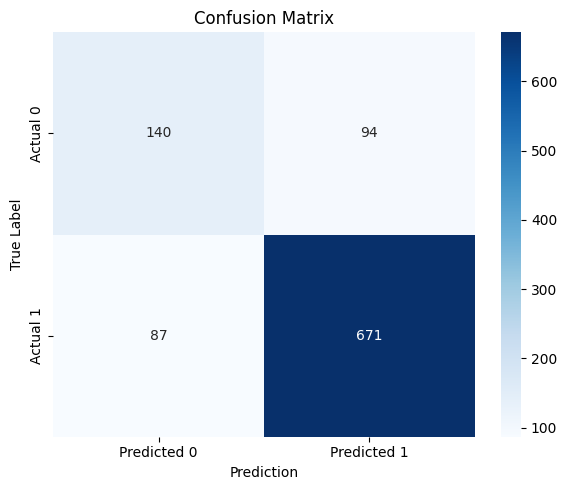

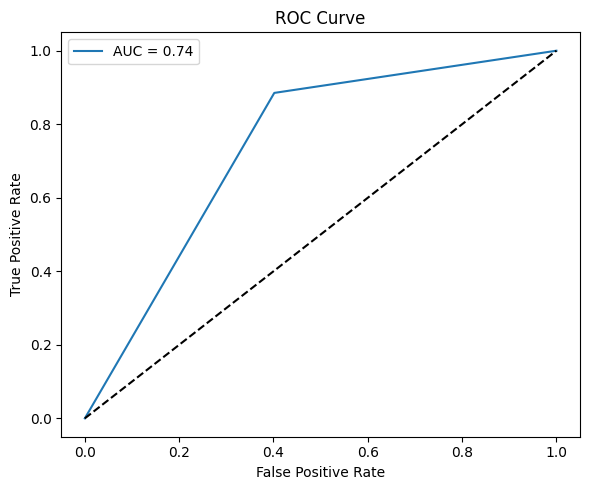

In [ ]:
# Evaluate model

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Get true and predicted labels ---
y_scores = predictions.output.detach().cpu().numpy().flatten()            # raw probabilities
y_pred = (y_scores > 0.5).astype(int)                                     # binary predictions
y_true = predictions.x["decoder_target"].detach().cpu().numpy().flatten() # ground truth

# --- Metrics ---
auc = roc_auc_score(y_true, y_scores)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)   # sensitivity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)

print(f"AUC: {auc:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Sensitivity (Recall): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")

# --- Confusion Matrix Plot ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# --- ROC Curve Plot ---
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pred = tft.predict(
    test_dataloader,
    mode="raw",
    return_x=True,
    return_index=True
)

# Access components
raw_predictions = pred.output
x = pred.x
index = pred.index

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
interpretation = tft.interpret_output(raw_predictions, reduction="mean")

# Plot decoder variable importance
importances = interpretation["decoder_variable_importance"].cpu().numpy()
variable_names = interpretation["decoder_variables"]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=variable_names)
plt.title("Feature Importance (Decoder)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


KeyError: 'decoder_variable_importance'

In [ ]:
print(interpretation.keys())

dict_keys(['attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'encoder_length_histogram', 'decoder_length_histogram'])
